In [1]:
from LSSTFringe import Sky   
from LSSTFringe import utils,plot_utils
%pylab inline
import lsst.sims.utils.ObservationMetaData as ObsMeta 
import galsim
import warnings
import astropy.units as u
warnings.filterwarnings('ignore')
# importing poisson fro scipy
from scipy.stats import poisson
plot_utils.init_plot_style()

Populating the interactive namespace from numpy and matplotlib


In [23]:
Fitting,uu,indices = utils.load_ccd_map('E2V-321')
pfs_interpolator = utils.load_interp(experiment='LSST')

In [2]:
Obs_meta = ObsMeta(pointingRA=5.497787143782138,
                   pointingDec=-1.519759751642230,bandpassName='y',rotSkyPos=0)

model = Sky.Sky(ra=Obs_meta.pointingRA,dec = Obs_meta.pointingDec,Mjd=58000)  

# Split sky background into two components
upperatm_count,up_wlen,up_spec = model.Count_upper_atm()
contiuum_count = model.Count_sky_continuum()

In [191]:
photParams = model.Phot_par()
exposureTime = photParams.nexp*photParams.exptime

upper_count = upperatm_count*exposureTime
# Adding noise to sky background
randomNum = galsim.UniformDeviate()
#noise = galsim.CCDNoise(randomNum,sky_level=0.0,gain=photParams.gain,read_noise=photParams.readnoise)
noise = galsim.PoissonNoise(randomNum)

# Making a galsim image for sky bg & upper Atm
image_cont = np.ones(shape = (3974,4000))*contiuum_count*exposureTime
galsim_image_cont = galsim.Image(image_cont, copy=True)

image_UpperAtm = np.ones(shape = (3974,4000))*upperatm_count*exposureTime
galsim_image_UpperAtm = galsim.Image(image_UpperAtm, copy=True)

# Adding noise to images
galsim_image_cont.addNoise(noise)
galsim_image_UpperAtm.addNoise(noise)

In [178]:
def gaussian(x, mu, sig):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma


    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

In [180]:
y_gau = gaussian(x,mu = np.mean(galsim_image_cont.array.flatten()), sig = photParams.readnoise)

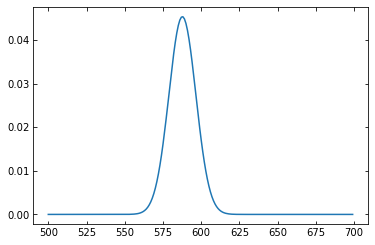

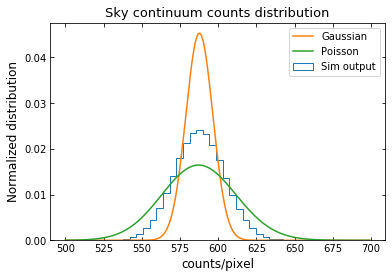

In [188]:
plt.title('Sky continuum counts distribution',fontsize = 13)
plt.hist(galsim_image_cont.array.flatten(),bins = 40,histtype='step',normed=True,label = 'Sim output')
x = np.arange(500, 700, 1)
plt.plot(x,y_gau,label = 'Gaussian')
y = poisson.pmf(x, mu=np.mean(galsim_image_cont.array.flatten()))
plt.plot(x, y,label = 'Poisson')
plt.ylabel('Normalized distribution', fontsize = 12)
plt.xlabel('counts/pixel',fontsize = 12)
plt.legend();
#plt.hist(theory,bins = 40,histtype='step');

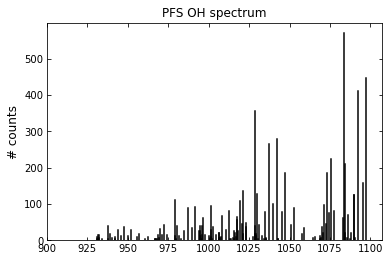

In [25]:

yband_QE = Sky.Sky().Bandpass()
yband = Sky.Sky().Bandpass()
detector = Sky.Sky().detector_throughputs()
yband.sb = yband.sb/detector
where_are_NaNs = isnan(yband.sb)
yband.sb[where_are_NaNs] = 0
mm = (yband.wavelen < 1100) & (yband.wavelen > 908)

def line_under_bandpass (PFS = False,Skybrightness = False,verbose = True):
    
    detector = Sky.Sky().detector_throughputs()
    yband = Sky.Sky().Bandpass()
    
    yband.sb = yband.sb/detector
    where_are_NaNs = isnan(yband.sb)
    yband.sb[where_are_NaNs] = 0
    
    if PFS == True: 
    
        line_wlen,line_int,l =Sky.OHlines().load_skyline()
        _,group_dir = Sky.OHlines().get_grouping(l)
        mask = (line_wlen > 908) & (line_wlen < 1099)
        
        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=line_wlen,line_int=line_int)
        intensity = c.conv()
        #line_intensity = intensity/np.sum(intensity)
        
        wavelengths = np.round(line_wlen[mask],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity 
        
        if verbose == True:
            print(line_count.shape)
        
    if Skybrightness == True:
        
        m = (up_wlen > 908.3) & (up_wlen < 1098.8)

        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=up_wlen[m],line_int=up_spec[0][m])
        intensity = c.conv()
        
        wavelengths = np.round(up_wlen[m],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity   
        
        if verbose == True:
            print(line_count.shape)
    
    return(wavelengths,line_count)

def plot_line (wavelen, intensity , color):
    for i in range(len(wavelen)):
        plt.plot([wavelen[i],wavelen[i]],[0,intensity[i]],color = 'black')
    plt.ylim(0,)
    
PFS_wavelengths, PFS_line_count = line_under_bandpass (PFS = True,verbose=False)
plot_utils.plot_line(PFS_wavelengths,PFS_line_count,'black')
plt.ylabel('# counts',fontsize = 12)
plt.title('PFS OH spectrum');

# Define some plotting utility functions
def plot_tt_amp (sim_res,l):
    tt = sim_res #+ image_cont
    plt.plot(np.diag(tt/np.mean(tt)-1)*100,label = l)
    plt.legend(frameon = False)
    plt.axhline(0,ls = '--',color = 'black')
    plt.ylabel('Fringing amplitude (%)',fontsize = 12)  

def plot_diag (sim):
    plt.plot((np.diag(sim)/np.mean(np.diag(sim))-1)*100)
    
def bg_image (sim_res,image_count = image_cont):
    galsim_image = galsim.Image(sim_res, copy=True)
    galsim_image.addNoise(noise)
    plt.imshow(galsim_image.array,cmap = 'gray',origin = 'lower')
    plt.colorbar()

In [ ]:

# Incident angle distribution and corresponding weight
angles_center,weight_center = utils.get_angle(theta_x=0,theta_y=0.)

In [34]:
def sim (wavelengths,line_count,interp,angles,angle_weight):
    sim_res = np.zeros(shape = Fitting.shape)
    for wlen,count_num in zip(wavelengths,line_count):
        int_f = interp[str(wlen)]
        ss = int_f(uu,angles)
        sst = ss.T
        total = np.sum(sst * angle_weight, axis = 1)
        final = total[indices]
        # adjust frinigng scale 
        sim_res += count_num*final.reshape(3974,4000)
        
    return(sim_res)


# Focal plane center
sim_pfs_center = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,interp= pfs_interpolator,angles = angles_center, angle_weight=weight_center)
# Fringing amplitude
amplitude = (sim_pfs_center/np.mean(sim_pfs_center)-1)

In [42]:
# Scale fringing amplitude for noise study
scale = 10

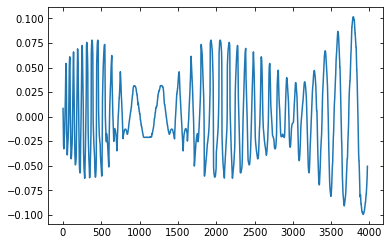

In [70]:
plt.plot(np.diag(amplitude*30))

In [199]:

#galsim_image = galsim.Image(sky_level*(1+amplitude*10), copy=True)

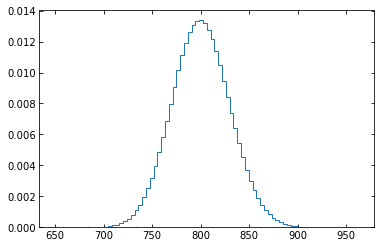

In [212]:
plt.hist(image.flatten(),bins = 80,histtype='step',normed=True,label = 'Sim output');



In [241]:
scales[5]

6

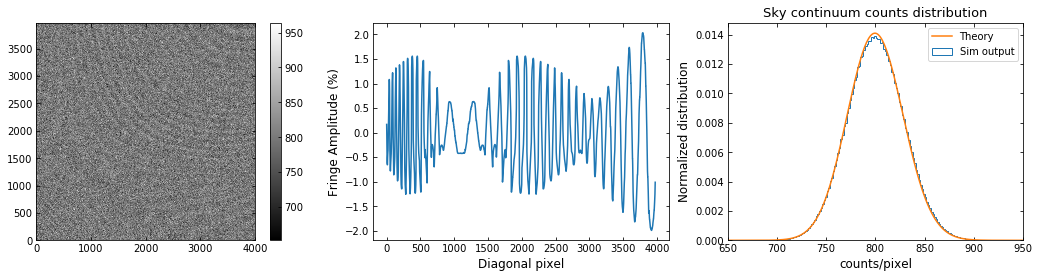

In [243]:
Skylevel = galsim.Image(np.ones(shape = (3974,4000))*800)
Skylevel.addNoise(noise)
scale = 6
plt.figure(figsize  = (18,4))
image = Skylevel.array*(1+amplitude*scale)
plt.subplot(131)
plt.imshow(image,origin='lower',cmap = 'gray')
plt.colorbar()
plt.subplot(132)
plt.plot(np.diag(amplitude*scale)*100)
plt.xlabel('Diagonal pixel',fontsize = 12)
plt.ylabel('Fringe Amplitude (%)',fontsize = 12)
#plt.ylim(-6.5,6.5)
plt.subplot(133)
plt.title('Sky continuum counts distribution',fontsize = 13)
plt.hist(image.flatten(),bins = 200,histtype='step',normed=True,label = 'Sim output')
x = np.arange(650, 950, 1)
y = poisson.pmf(x, mu=np.mean(image))
plt.plot(x, y,label = 'Theory')
plt.xlim(650,950)
plt.ylabel('Normalized distribution', fontsize = 12)
plt.xlabel('counts/pixel',fontsize = 12)
plt.legend();

In [239]:
scales = np.arange(1,21,1)
Skylevel = galsim.Image(np.ones(shape = (3974,4000))*800)
Skylevel.addNoise(noise)
for q in range(len(scales)):
    plt.figure(figsize  = (18,4))
    image = Skylevel.array*(1+amplitude*scales[q])
    plt.subplot(131)
    plt.imshow(image,origin='lower',cmap = 'gray')
    plt.colorbar()
    plt.subplot(132)
    plt.plot(np.diag(amplitude*scales[q])*100)
    plt.xlabel('Diagonal pixel',fontsize = 12)
    plt.ylabel('Fringe Amplitude (%)',fontsize = 12)
    plt.ylim(-6.5,6.5)
    plt.subplot(133)
    plt.title('Sky continuum counts distribution',fontsize = 13)
    plt.hist(image.flatten(),bins = 200,histtype='step',normed=True,label = 'Sim output')
    x = np.arange(650, 950, 1)
    y = poisson.pmf(x, mu=np.mean(image))
    plt.plot(x, y,label = 'Theory')
    plt.xlim(650,950)
    plt.ylabel('Normalized distribution', fontsize = 12)
    plt.xlabel('counts/pixel',fontsize = 12)
    plt.legend();
    plt.savefig('data/gif/%i.png'%(q+100))
    plt.close()
    #plt.hist(theory,bins = 40,histtype='step');

In [160]:
import os
import imageio

In [240]:
files= os.listdir('data/gif/')
files.sort()
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
if 'movie.gif' in files:
    files.remove('movie.gif')
if '.DS_Store' in files:
    files.remove('.DS_Store')
files.remove('.png')    
os.chdir('data/gif/')
images = [imageio.imread(file) for file in files]
imageio.mimwrite('movie.gif',images,fps = 2)
os.chdir('../..')

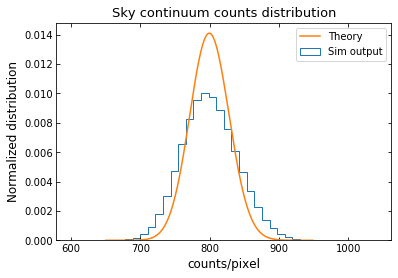

In [100]:
plt.title('Sky continuum counts distribution',fontsize = 13)
plt.hist(galsim_image.array.flatten(),bins = 40,histtype='step',normed=True,label = 'Sim output')
x = np.arange(650, 950, 1)
y = poisson.pmf(x, mu=np.mean(galsim_image.array.flatten()))
plt.plot(x, y,label = 'Theory')
plt.ylabel('Normalized distribution', fontsize = 12)
plt.xlabel('counts/pixel',fontsize = 12)
plt.legend();
#plt.hist(theory,bins = 40,histtype='step');